## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 6

### Background

In this project we will use the `emcee` MCMC EnsembleSampler to map the posterior distribution of a multivariate Gaussian with a strong correlation between the parameters and two additional "noise" peaks. It represents an example of best-fit parameters of a multi-dimensional fit with strong degeneracies, such as in linear regression. The additional "noise" maxima may be produced by significant outliers, and even though they have small amplitudes, they may still confuse simple maximization methods. 

The likelihood is given by the sum of three components

$$
    {\cal L}(\mathbf{p}) = 
    \frac{1}{\mathrm{det}(\mathbf{\Sigma}_1)^{1/2}} \;
    \exp\left( -\frac{1}{2} (\mathbf{p}-\boldsymbol\mu_1)^T \, \mathbf{\Sigma}_1^{-1} \, (\mathbf{p}-\boldsymbol\mu_1) \right)
    + 0.01 \sum_{n=2,3}\ \frac{1}{\mathrm{det}(\mathbf{\Sigma}_n)^{1/2}} \;
    \exp\left( -\frac{1}{2} (\mathbf{p}-\boldsymbol\mu_n)^T \, \mathbf{\Sigma}_n^{-1} \, (\mathbf{p}-\boldsymbol\mu_n) \right)
$$

Let's take the vector of parameters $\mathbf{p}$ to have three components (dimensions). The target means are all the same $\boldsymbol\mu_1[i] = -3.0$, for $i=0,1,2$, while the noise means are $\boldsymbol\mu_2[i] = 1.0$ and $\boldsymbol\mu_3[i] = 0.0$ for all $i$.

Correlations between the parameters are described by the following covariance matrices:

$$
    \mathbf{\Sigma}_1 = \begin{pmatrix} 
        1.0 & 0.9 & 0 \\ 
        0.9 & 1.0 & 0 \\ 
        0 & 0 & 1.0 \end{pmatrix}
$$

The off-diagonal terms correspond to the correlation coefficient $r=0.9$ between the first and second parameter.

The noise covariance matrices:

$$
    \mathbf{\Sigma}_2 = \begin{pmatrix} 
        0.25 & 0.1  & 0 \\ 
        0.1  & 0.25 & 0 \\ 
        0    & 0    & 0.25 \end{pmatrix}
    \qquad
    \mathbf{\Sigma}_3 = \begin{pmatrix} 
        0.25 & -0.1 & 0 \\ 
        -0.1 & 0.25 & 0 \\ 
        0    & 0    & 0.25 \end{pmatrix}
$$

You can use for your analysis either the combined chain of all walkers, which can be accessed as a 2D array `sampler.flatchain[step,parameter]`, or individual walker chains, which can be accessed as 3D arrays `sampler.chain[walker,step,parameter]`.

The autocorrelation time calculation may return an error when the chain is too short. You may suppress the error and turn it into a warning by setting the `quiet` parameter: `sampler.get_autocorr_time(quiet=True)`. Alternatively, you can set the parameter that controls the minimum number of autocorrelation times needed to trust the estimate `tol` to 5 or 10 instead of the default 50: `sampler.get_autocorr_time(tol=10)`.

### Learning goals

* Practice running an efficient MCMC ensemble sampler to reach numerical convergence of the model parameters.


* Compare results of MCMC sampler with direct maximization of the likelihood in the presence of measurement noise and false peaks. Determine which approach more reliably maps the parameter distributions.


* Derive most accurate estimates of the parameter distributions using burn-in of initial guesses and chain thinning to minimize autocorrelations within the chain.

### Task

__Required part:__

1. Write the `logLikelihood` and `logPosterior` functions for the above distribution, choosing appropriately wide priors. An example of coding the multivariate Gaussian is in class notebook for Week 9.<br>

2. Run direct maximization of the likelihood with Scipy as in previous projects. Does it recover the target parameters $\boldsymbol\mu_1$ and $\mathbf{\Sigma}_1$?<br>

3. Initialize the `emcee` sampler in random locations for 100 walkers. Run it for at least 500 steps to get preliminary estimates of the autocorrelation time and parameter values. Compare the means, standard deviations, and the correlation coefficient of the first two parameters with the target.<br>

4. Run an additional required number of __burn-in__ steps, based on the first estimate of $N_{corr}\;$. Using this chain, update an estimate of $N_{corr}\;$ and the parameter values. Then reset the chain, discarding the burn-in samples but keeping the `state` of the sampler.<br>

5. Now run the sampler until the __mean__ and __standard deviation__ of each parameter individually converge to 1% relative accuracy. Do it in chunks of steps of length $10 N_{corr}\;$. After each chunk, keep updating the value of $N_{corr}\;$. Calculate the parameter values using the appropriately __thinned__ chain.<br>

6. Plot the first few hundred steps of the new chain and check that the estimated value of $N_{corr}\;$ corresponds to a visible correlation between the sequential values of all three parameters. Which parameter has the largest $N_{corr}\;$?<br>

7. Use the `corner` routine to plot the thinned chain. Do the estimated parameter values correspond to the target?<br>

8. Plot the distribution of the first parameter from the thinned chain, using KDE. Superimpose the Gaussian distribution with the calculated mean and standard deviation, and the Gaussian corresponding to the target distribution. Is there a good match?

# 1.
Write the `logLikelihood` and `logPosterior` functions for the above distribution, choosing appropriately wide priors. An example of coding the multivariate Gaussian is in class notebook for Week 9.<br>

In [251]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')
import emcee
import corner
import scipy.optimize as opt
import pandas as pd

In [252]:
np.random.seed(0)

ndim = 3
mu1 = np.full(3, -3.0)
mu2 = np.full(3, 1.0)
mu3 = np.full(3, 0.0)

cov1 = np.array([[1.0, 0.9, 0.0], [0.9, 1.0, 0.0], [0.0, 0.0, 1.0]])
cov2 = np.array([[0.25, 0.1, 0.0], [0.1, 0.25, 0.0], [0.0, 0.0, 0.25]])
cov3 = np.array([[0.25, -0.1, 0.0], [-0.1, 0.25, 0.0], [0.0, 0.0, 0.25]])

# calculate inverse covariance matrix
icov1 = np.linalg.inv(cov1)
icov2 = np.linalg.inv(cov2)
icov3 = np.linalg.inv(cov3)

# log likelihood function
def logLikelihood(p):
    diff1 = p - mu1
    diff2 = p - mu2
    diff3 = p - mu3

    L1 = np.linalg.det(cov1 ** (1/2)) * np.exp(-0.5 * np.dot(diff1, np.dot(icov1, diff1)))
    L2 = np.linalg.det(cov2 ** (1/2)) * np.exp(-0.5 * np.dot(diff2, np.dot(icov2, diff2)))
    L3 = np.linalg.det(cov3 ** (1/2)) * np.exp(-0.5 * np.dot(diff3, np.dot(icov3, diff3)))

    return np.log(L1 + 0.01 * (L2 + L3))

$$
    {\cal L}(\mathbf{p}) = 
    \frac{1}{\mathrm{det}(\mathbf{\Sigma}_1)^{1/2}} \;
    \exp\left( -\frac{1}{2} (\mathbf{p}-\boldsymbol\mu_1)^T \, \mathbf{\Sigma}_1^{-1} \, (\mathbf{p}-\boldsymbol\mu_1) \right)
    + 0.01 \sum_{n=2,3}\ \frac{1}{\mathrm{det}(\mathbf{\Sigma}_n)^{1/2}} \;
    \exp\left( -\frac{1}{2} (\mathbf{p}-\boldsymbol\mu_n)^T \, \mathbf{\Sigma}_n^{-1} \, (\mathbf{p}-\boldsymbol\mu_n) \right)
$$

# 2. 
Run direct maximization of the likelihood with Scipy as in previous projects. Does it recover the target parameters $\boldsymbol\mu_1$ and $\mathbf{\Sigma}_1$?<br>

In [253]:
result = opt.minimize(neglogLikelihood, [-3.05, -2.9, -3.1])
print(result)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.302585093017292
        x: [-3.000e+00 -3.000e+00 -3.000e+00]
      nit: 4
      jac: [-4.768e-07  4.768e-07  6.795e-06]
 hess_inv: [[ 1.000e+00  9.000e-01  6.053e-05]
            [ 9.000e-01  1.000e+00 -6.149e-05]
            [ 6.053e-05 -6.149e-05  9.908e-01]]
     nfev: 24
     njev: 6


/var/folders/p4/n6vrnd9x0h9c9khd9m8mfbfw0000gn/T/ipykernel_98194/2965711474.py:25: RuntimeWarning: invalid value encountered in sqrt
  L3 = np.linalg.det(cov3 ** (1/2)) * np.exp(-0.5 * np.dot(diff3, np.dot(icov3, diff3)))


Yes, this direct maximiation of the likelihood recovers the means=[-3, -3, -3], as well as the first covariance matrix.

# 3. 
Initialize the `emcee` sampler in random locations for 100 walkers. Run it for at least 500 steps to get preliminary estimates of the autocorrelation time and parameter values. Compare the means, standard deviations, and the correlation coefficient of the first two parameters with the target.<br>

In [254]:
def neglogLikelihood(p):
    return -logLikelihood(p)

def logPrior(p):
    if (-10 < p[0] < 10) and (-10 < p[1] < 10) and (-10 < p[2] < 10):
        return 0          # log of constant 1
    else:
        return -np.inf    # otherwise, log of zero

def logPosterior(p):
    return logPrior(p) + logLikelihood(p)

ndim = 3
nwalkers = 100

np.random.seed(0)  # initialize the random number generator for reproducible results

# Choose an initial set of positions for the walkers
p = np.array([-3., -3., -3.])
p0 = [p + 0.1 * np.random.rand(ndim) for i in range(nwalkers)]

# Initialize the sampler with the chosen specs
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

In [255]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

initial_steps = 500
pos, prob, state = sampler.run_mcmc(p0, initial_steps)

acorr = sampler.get_autocorr_time(tol=10) # autocorrelation time for all parameters
ncorr = int(acorr[0]) # choose a single integer value (for the first parameter)

print('nburn = %d expected nburn = %d' % (initial_steps, 20 * ncorr))
print("Autocorrelation length =", acorr)

/var/folders/p4/n6vrnd9x0h9c9khd9m8mfbfw0000gn/T/ipykernel_98194/2965711474.py:25: RuntimeWarning: invalid value encountered in sqrt
  L3 = np.linalg.det(cov3 ** (1/2)) * np.exp(-0.5 * np.dot(diff3, np.dot(icov3, diff3)))


nburn = 500 expected nburn = 440
Autocorrelation length = [22.82926697 22.15414467 21.9416088 ]


In [256]:
flat_samples = sampler.flatchain[:, :]

# Calculate the mean and standard deviation for each parameter (columns 0 and 1)
mean_param1 = np.mean(flat_samples[:, 0])
std_param1 = np.std(flat_samples[:, 0])
mean_param2 = np.mean(flat_samples[:, 1])
std_param2 = np.std(flat_samples[:, 1])

# Calculate the correlation coefficient between the first two parameters
correlation_coeff = np.corrcoef(flat_samples[:, 0], flat_samples[:, 1])[0, 1]

# Print results
print(f"Mean of parameter 1: {mean_param1:.3f} (Target: {mu1[0]})")
print(f"Standard deviation of parameter 1: {std_param1:.3f} (Target: {np.sqrt(cov1[0,0])})")
print(f"Mean of parameter 2: {mean_param2:.3f} (Target: {mu1[1]})")
print(f"Standard deviation of parameter 2: {std_param2:.3f} (Target: {np.sqrt(cov1[1,1])})")
print(f"Correlation coefficient of parameters 1 and 2: {correlation_coeff:.3f} (Target: {cov1[0,1] / np.sqrt(cov1[0,0] * cov1[1,1])})")

Mean of parameter 1: -2.987 (Target: -3.0)
Standard deviation of parameter 1: 1.012 (Target: 1.0)
Mean of parameter 2: -2.982 (Target: -3.0)
Standard deviation of parameter 2: 1.018 (Target: 1.0)
Correlation coefficient of parameters 1 and 2: 0.903 (Target: 0.9)


These means and standard deviations look close to their expected values, which shows that this method is in general on the right path.

# 4. 
Run an additional required number of __burn-in__ steps, based on the first estimate of $N_{corr}\;$. Using this chain, update an estimate of $N_{corr}\;$ and the parameter values. Then reset the chain, discarding the burn-in samples but keeping the `state` of the sampler.<br>

In [257]:
nburn = 420    # a guess for the burn-in size

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
pos, prob, state = sampler.run_mcmc(p0, nburn)

acorr = sampler.get_autocorr_time(tol=10) # autocorrelation time for all parameters
ncorr = int(acorr[0]) # choose a single integer value (for the first parameter)

print('nburn = %d expected nburn = %d' % (nburn, 20 * ncorr))

print('p1 = %.3f +- %.3f  p2 = %.3f +- %.3f  p3 = %.1f +- %.1f'\
    %(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]),
     np.mean(sampler.flatchain[:,1]), np.std(sampler.flatchain[:,1]),
     np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2])))

sampler.reset()

/var/folders/p4/n6vrnd9x0h9c9khd9m8mfbfw0000gn/T/ipykernel_98194/2965711474.py:25: RuntimeWarning: invalid value encountered in sqrt
  L3 = np.linalg.det(cov3 ** (1/2)) * np.exp(-0.5 * np.dot(diff3, np.dot(icov3, diff3)))


nburn = 420 expected nburn = 420
p1 = -3.000 +- 1.015  p2 = -2.994 +- 1.023  p3 = -3.0 +- 1.1


# 5. 
Now run the sampler until the __mean__ and __standard deviation__ of each parameter individually converge to 1% relative accuracy. Do it in chunks of steps of length $10 N_{corr}\;$. After each chunk, keep updating the value of $N_{corr}\;$. Calculate the parameter values using the appropriately __thinned__ chain.<br>

In [258]:
pmean = np.zeros(ndim)
not_converged = True
nchain = 0
nsteps = 10 * ncorr

while not_converged:
    # starting from the last position in the chain, sample nsteps
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)
    
    nchain += nsteps
    
    acorr = sampler.get_autocorr_time(tol=5) # autocorrelation time for all parameters
    ncorr = int(acorr[0])                     # choose a single integer value

    # mean values of the parameters
    pmean_last = np.copy(pmean)
    pmean = np.mean(sampler.flatchain[::ncorr], axis=0)
    
    # convergence criterion
    rel_err1 = abs((pmean[0] - pmean_last[0]) / pmean[0])
    rel_err2 = abs((pmean[1] - pmean_last[1]) / pmean[1])
    rel_err3 = abs((pmean[2] - pmean_last[2]) / pmean[2])
    converged1 = rel_err1 < 0.01
    converged2 = rel_err2 < 0.01
    converged3 = rel_err3 < 0.01

    if (converged1 == True) and (converged2 == True) and (converged3 == True):
        not_converged = False
        
    print('p1 = %.3f +- %.3f  p2 = %.3f +- %.3f  p3 = %.1f +- %.1f'\
        %(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]),
        np.mean(sampler.flatchain[:,1]), np.std(sampler.flatchain[:,1]),
        np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2])), 'nchain =', nchain)

print(f'Mean acceptance fraction = {np.mean(sampler.acceptance_fraction):.3f}')

/var/folders/p4/n6vrnd9x0h9c9khd9m8mfbfw0000gn/T/ipykernel_98194/2965711474.py:25: RuntimeWarning: invalid value encountered in sqrt
  L3 = np.linalg.det(cov3 ** (1/2)) * np.exp(-0.5 * np.dot(diff3, np.dot(icov3, diff3)))


p1 = -2.970 +- 0.994  p2 = -2.975 +- 0.992  p3 = -3.0 +- 1.0 nchain = 210
p1 = -2.994 +- 1.018  p2 = -2.974 +- 1.007  p3 = -3.0 +- 1.0 nchain = 420
p1 = -2.996 +- 1.014  p2 = -2.985 +- 1.007  p3 = -3.0 +- 1.0 nchain = 630
p1 = -3.000 +- 1.013  p2 = -2.991 +- 1.011  p3 = -3.0 +- 1.0 nchain = 840
p1 = -2.992 +- 1.019  p2 = -2.986 +- 1.016  p3 = -3.0 +- 1.0 nchain = 1050
p1 = -2.986 +- 1.022  p2 = -2.976 +- 1.017  p3 = -3.0 +- 1.0 nchain = 1260
Mean acceptance fraction = 0.645


# 6. 
Plot the first few hundred steps of the new chain and check that the estimated value of $N_{corr}\;$ corresponds to a visible correlation between the sequential values of all three parameters. Which parameter has the largest $N_{corr}\;$?<br>

In [259]:
acorr = sampler.get_autocorr_time(tol=5)
acorr

array([29.76068347, 29.46334894, 29.96157456])

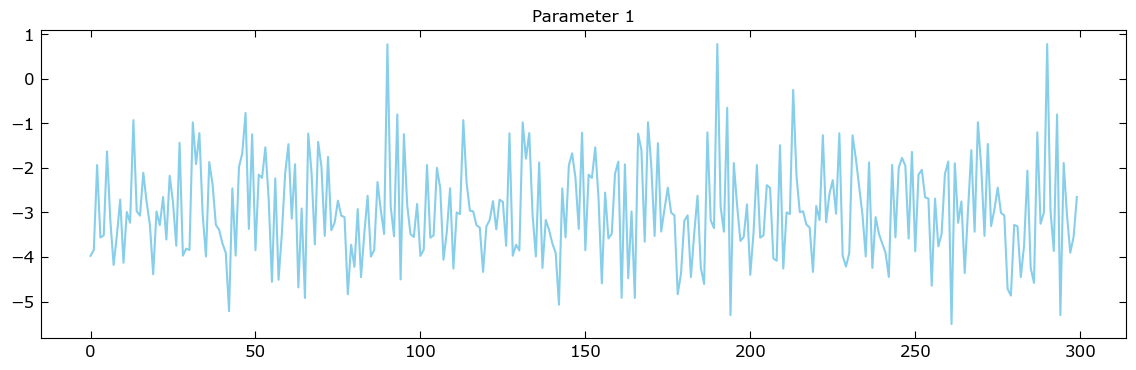

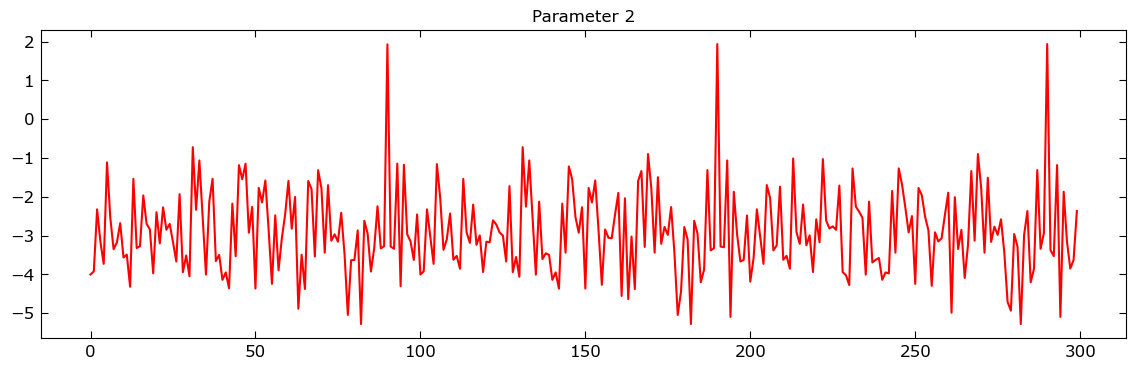

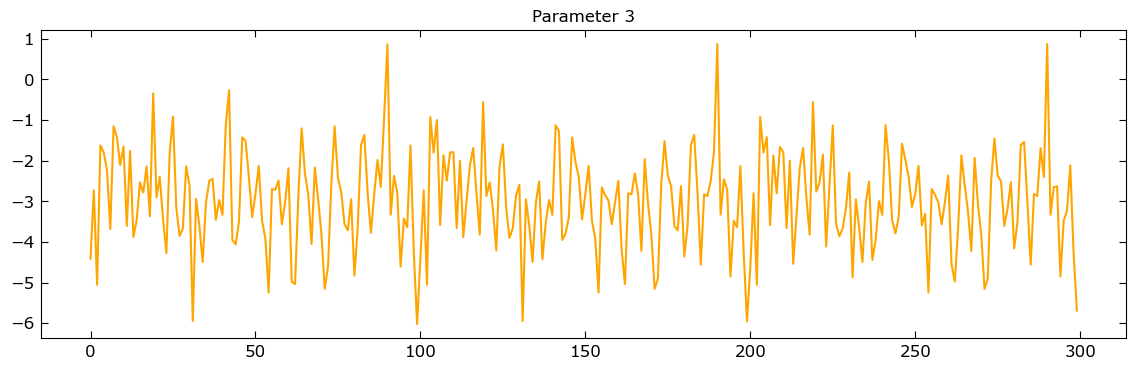

In [260]:
plt.figure(figsize=(14, 4))
plt.title('Parameter 1')
plt.plot(sampler.flatchain[:300, 0], color='skyblue', label='parameter 1')
plt.figure(figsize=(14, 4))
plt.title('Parameter 2')
plt.plot(sampler.flatchain[:300, 1], color='r', label='parameter 2')
plt.figure(figsize=(14, 4))
plt.title('Parameter 3')
plt.plot(sampler.flatchain[:300, 2], color='orange', label='parameter 3')

Parameter 1 has the longest N_corr, and from the plots we can see that it takes slightly longer to change its values than the other two parameters. Parameter 3 clearly is the quickest to change.

# 7. 
Use the `corner` routine to plot the thinned chain. Do the estimated parameter values correspond to the target?<br>

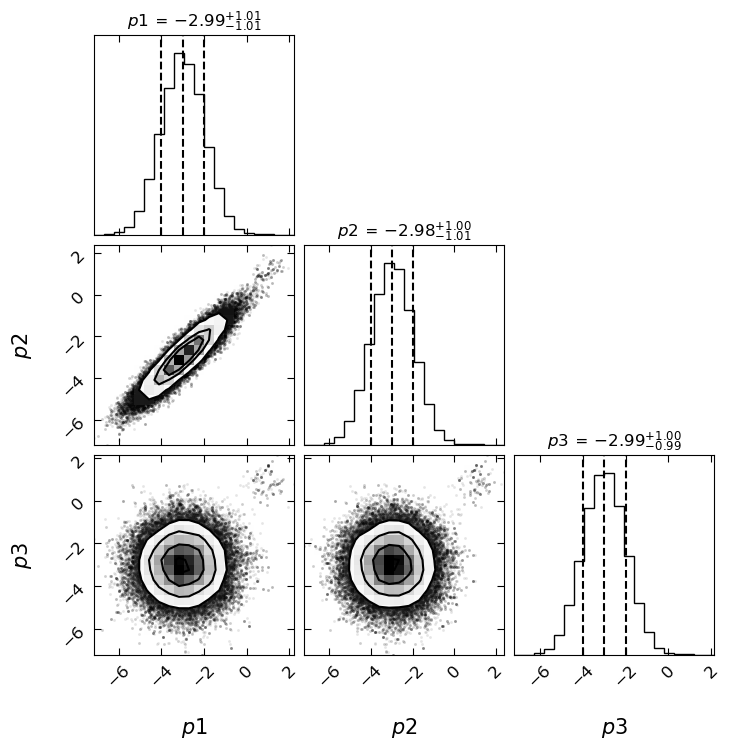

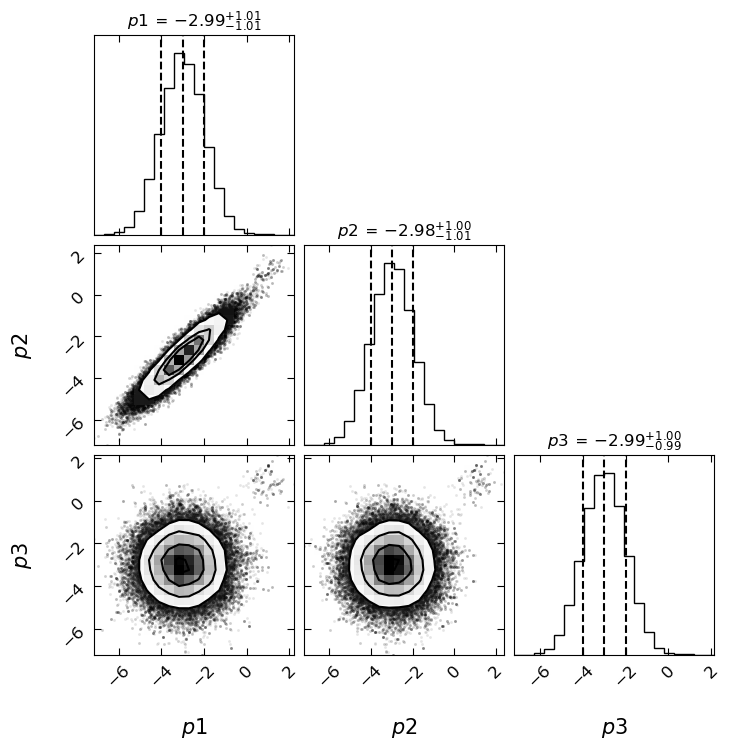

In [261]:
corner.corner(sampler.flatchain, labels=[r'$p1$', r'$p2$', r'$p3$'],
              quantiles=[0.16, 0.5, 0.84], show_titles=True)

Yes, the estimated parameters lie very close to -3, and the standard deviations appear very close to 1.

# 8. 
Plot the distribution of the first parameter from the thinned chain, using KDE. Superimpose the Gaussian distribution with the calculated mean and standard deviation, and the Gaussian corresponding to the target distribution. Is there a good match?

In [262]:
p1_thinned = sampler.flatchain[::ncorr][:, 0]
p2_thinned = sampler.flatchain[::ncorr][:, 1]
p3_thinned = sampler.flatchain[::ncorr][:, 2]

In [263]:
# getting optimal h_0 for each parameter

percentile25 = pd.Series(p1_thinned).quantile(0.25)
percentile75 = pd.Series(p1_thinned).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(p1_thinned)
h_0_p1 = 0.9 * np.min([IQR / 1.34, sigma]) * len(p1_thinned) ** (-1/5)
print('h_0_p1:', round(h_0_p1, 4))

percentile25 = pd.Series(p2_thinned).quantile(0.25)
percentile75 = pd.Series(p2_thinned).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(p2_thinned)
h_0_p2 = 0.9 * np.min([IQR / 1.34, sigma]) * len(p2_thinned) ** (-1/5)
print('h_0_p2:', round(h_0_p2, 4))

percentile25 = pd.Series(p3_thinned).quantile(0.25)
percentile75 = pd.Series(p3_thinned).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(p3_thinned)
h_0_p3 = 0.9 * np.min([IQR / 1.34, sigma]) * len(p3_thinned) ** (-1/5)
print('h_0_p3:', round(h_0_p3, 4))

h_0_p1: 0.1715
h_0_p2: 0.1711
h_0_p3: 0.1696


In [264]:
p1_x = np.linspace(np.min(p1_thinned), np.max(p1_thinned), 100)
p2_x = np.linspace(np.min(p2_thinned), np.max(p2_thinned), 100)
p3_x = np.linspace(np.min(p3_thinned), np.max(p3_thinned), 100)

# define Epanechnikov kernel
def K_Epan(u):
    if abs(u) <= 1:
        return .75 * (1 - u ** 2)
    else:
        return 0

def KDE_Epan_h(x, h, data):
    sum = 0
    N = len(data) 
    # sum over all data points
    for i in range(len(data)):
        sum += K_Epan((x - data[i]) / h) / h
    return sum / N

In [265]:
# function for Gaussian distribution
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

p1_mu = np.mean(p1_thinned)
p2_mu = np.mean(p2_thinned)
p3_mu = np.mean(p3_thinned)

p1_sigma = np.std(p1_thinned)
p2_sigma = np.std(p2_thinned)
p3_sigma = np.std(p3_thinned)

p1_max = np.max(p1_thinned)
p2_max = np.max(p2_thinned)
p3_max = np.max(p3_thinned)

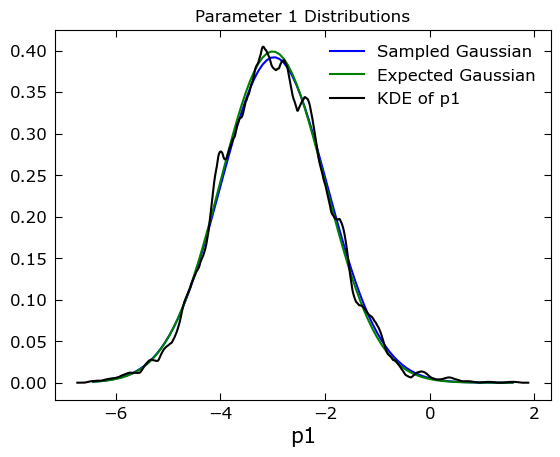

In [266]:
x_list = []
y_list = []
num_points = 1000

# loop over range of Fe/H from -3 to 1
for x in np.linspace(p1_x[0] - 0.3, p1_x[-1] + 0.3, int(num_points)):
    x_list.append(x)
    y_list.append(KDE_Epan_h(x, h_0_p1, p1_thinned))

y_gaussian = []
y_gaussian_expected = []
for x in p1_x:
    y_gaussian.append(gaussian(x, p1_mu, p1_sigma))
    y_gaussian_expected.append(gaussian(x, -3.0, 1.0))

plt.plot(p1_x, y_gaussian, color='b', label='Sampled Gaussian')
plt.plot(p1_x, y_gaussian_expected, color='g', label='Expected Gaussian')
plt.plot(x_list, y_list, color='k', label='KDE of p1')
plt.xlabel('p1')
plt.title('Parameter 1 Distributions')
plt.legend()

There is a very good match. So good in fact it is almost hard to visually separate the three plots. MCMC clearly resulted in a good estimate of the sample's mean and standard deviation.

# Concluding Assessment:

Numerical methods which worked or did not work in this project:
* The straight-forward maximization of the loglikelihood function worked well, as it returned the expected means and a covariance matrix very close to the input matrix.
* The MCMC method worked, especially when combined with burn-in steps and thinning. And it didn't take our code that long to run, although we only required a 1% accruacy, which could have easily been decreased. More steps would have been needed then, however, to get more accurate results.
* The resulting Gaussian estimated from the thinned chain was very similar to the expected gaussian, displaying the effectiveness of MCMC.

Lessons learned:
* MCMC can be a good method to estimate parameters if there are a lot of parameters, and if no other method adapts well to the dataset.
* Using burn-in steps and thinning of MCMC chains help produce more accurate results.

Further code improvements I could make with significantly more effort:
* I could have explored the effects of thinning more, and what thinning strategies produce the optimal results.
* I might have attempted to lower the acceptance criterion further and explored ways to limit the computation time while still getting more accruate results.